In [0]:
#로컬 파일 경로 
import os 
path=os.getcwd()
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/new_data
/content/.config/active_config
/content/.config/.last_survey_prompt.yaml
/content/.config/.last_update_check.json
/content/.config/gce
/content/.config/.last_opt_in_prompt.yaml
/content/.config/config_sentinel
/content/.config/.metricsUUID
/content/.config/logs/2020.06.10/16.28.00.889996.log
/content/.config/logs/2020.06.10/16.27.42.054200.log
/content/.config/logs/2020.06.10/16.27.29.206693.log
/content/.config/logs/2020.06.10/16.28.00.359521.log
/content/.config/logs/2020.06.10/16.27.11.187541.log
/content/.config/logs/2020.06.10/16.27.46.450102.log
/content/.config/configurations/config_default
/content/sample_data/README.md
/content/sample_data/anscombe.json
/content/sample_data/mnist_test.csv
/content/sample_data/california_housing_test.csv
/content/sample_data/mnist_train_small.csv
/content/sample_data/california_housing_train.csv


In [0]:
import pandas as pd 
df_y = pd.read_pickle("/content/new_data")

In [0]:
df_y.head()

,overall,reviewText,summary,pretreatment
0,5.0,this is a great cd full of worship favorites!!...,great worship cd,great cd full worship favorite time great ke...
1,5.0,"so creative! love his music - the words, the ...",gotta listen to this!,creative love music word message favorite ...
2,5.0,"keith green, gone far to early in his carreer,...",great approach still gets the message out,keith green gone far early carreer left u go...
3,5.0,keith green had his special comedy style of ch...,great a must have,keith green special comedy style chirstian mus...
4,5.0,keith green / so you wanna go back to egypt......,a great one from keith with a guest appearance...,keith green wan na go back egypt : album kei...


In [0]:
#overall 1,2 -> 0(부정)/ 4,5->1(긍정)으로 변환해야 함. 
df2=df_y.replace({'overall': {1:0, 2:0, 5: 1, 4: 1}}).copy()
df2=df2[df2.overall != 3]
print(df2.shape)
df_bad = df2[df2.overall == 0]
df_good = df2[df2.overall == 1]
df_good = df_good[0:1432]

df_class = pd.concat([df_good, df_bad])

(28914, 4)


In [0]:
print(df_bad.shape)
print(df_good.shape)
print(df_class.shape)

(1432, 4)
(1432, 4)
(2864, 4)


[0.0, 1.0]


Text(0, 0.5, 'number')

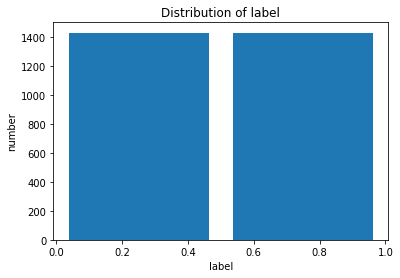

In [0]:
# 부정 긍정 라벨 몇개인지 확인. 밸런스 안맞으면 데이터 잘라서 맞추기  코드 추가하기 
import matplotlib.pyplot as plt
stars=df_class['overall']
print(sorted(stars.unique())) #고유값 나열
plt.hist(stars, bins=2, rwidth=0.85)
plt.title('Distribution of label')
plt.xlabel('label')
plt.ylabel('number')

In [0]:
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [0]:
texts_y=[]
for line in df_class['pretreatment']:
    texts_y.append(line)

In [0]:
print(len(texts_y),texts_y[0])

2864 great cd full worship favorite   time great keith green songs best album far 


In [0]:
from tensorflow.python.keras.datasets import reuters
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.keras.models import load_model

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(texts_y)

threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)


단어 집합(vocabulary)의 크기 : 11830
등장 빈도가 6번 이하인 희귀 단어의 수: 9836
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 1994
단어 집합에서 희귀 단어의 비율: 83.14454775993238
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 17.839214184426528


In [0]:
import numpy as np
text_len = [len(s.split()) for s in df_class['pretreatment']]

#print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))


텍스트의 최대 길이 : 811
텍스트의 평균 길이 : 33.97974860335196


In [0]:
src_vocab=1230
maxlen2=50
t2=Tokenizer(num_words = src_vocab)
t2.fit_on_texts(texts_y)
sequences2=t2.texts_to_sequences(texts_y)
texts_pad=sequence.pad_sequences(sequences2,maxlen=maxlen2,padding='post',truncating='post')

# lstm 모델1

In [0]:
#train data, test data 분리
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(texts_pad, to_categorical(df_class['overall']), test_size = 0.1, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state=1)

In [0]:
y_model = Sequential()
y_model.add(Embedding(4300, 120))
y_model.add(LSTM(120))
y_model.add(Dense(2, activation='softmax'))

In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('you2_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [0]:
y_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
history4 = y_model.fit(x_train, y_train, batch_size=128, epochs=100, callbacks=[es, mc], validation_data=(x_val, y_val))


Epoch 1/100
19/19 [==============================] - ETA: 0s - loss: 0.6874 - acc: 0.5632
Epoch 00001: val_acc improved from -inf to 0.56202, saving model to you2_model.h5
19/19 [==============================] - 3s 173ms/step - loss: 0.6874 - acc: 0.5632 - val_loss: 0.6804 - val_acc: 0.5620
Epoch 2/100
18/19 [===========================>..] - ETA: 0s - loss: 0.5172 - acc: 0.7283
Epoch 00002: val_acc improved from 0.56202 to 0.79457, saving model to you2_model.h5
19/19 [==============================] - 3s 148ms/step - loss: 0.5173 - acc: 0.7283 - val_loss: 0.4574 - val_acc: 0.7946
Epoch 3/100
18/19 [===========================>..] - ETA: 0s - loss: 0.2846 - acc: 0.8958
Epoch 00003: val_acc improved from 0.79457 to 0.88760, saving model to you2_model.h5
19/19 [==============================] - 3s 151ms/step - loss: 0.2835 - acc: 0.8965 - val_loss: 0.2814 - val_acc: 0.8876
Epoch 4/100
18/19 [===========================>..] - ETA: 0s - loss: 0.1649 - acc: 0.9505
Epoch 00004: val_acc did 

In [0]:
loaded_model = load_model('you2_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(x_test, y_test)[1]))

9/9 [==============================] - 0s 14ms/step - loss: 0.2514 - acc: 0.8885

 테스트 정확도: 0.8885


In [0]:
accu_plot(history4)

NameError: ignored

# lstm 모델 2

In [0]:
from sklearn.model_selection import StratifiedKFold
kfold=StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
cvscores=[]
X=texts_pad
Y=df2_y['sentiment']
num=0
index_right=[]
index_wrong=[]


        for train, test in kfold.split(X,Y):
            i_r=[]
            i_w=[]
            y_model = Sequential()
            y_model.add(Embedding(4300, 100))
            #수정
            y_model.add(LSTM(100, return_sequences=True, recurrent_dropout=0.4))
            y_model.add(LSTM(100, return_sequences=True))
            y_model.add(Dropout(0.5))
            y_model.add(LSTM(100))
            y_model.add(Dense(2, activation='softmax'))
            y_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
            history3 = y_model.fit(X[train], to_categorical(Y[train]), batch_size=128, epochs=30, verbose=0)
            scores=y_model.evaluate(X[test], to_categorical(Y[test]),verbose=0)
            print("%s: %.2f%%" % (y_model.metrics_names[1], scores[1]*100))
            cvscores.append(scores[1] * 100)
            y_model.save_weights('checkpoints_c/lstm3/my_checkpoint'+str(num))


            ynew = y_model.predict_classes(X[test])
            file_name='predict_count/lstm3/predict_wrong'+str(num)+'.txt'
            f = open(file_name, "w")
            file_name2='predict_count/lstm3/predict_right'+str(num)+'.txt'
            f2 = open(file_name2, "w")
            for i, real in enumerate(Y[test]):
        
                line=''
                for integer in X[test][i]:
                    for word, index in t2.word_index.items():
                        if index == integer:
                            line+=(' '+word)
                    #print(line, y_test[i], ynew[i])
                if(real!=ynew[i]):
                    f.write("index: %s, real:%s, predict:%s\n%s\n" % (str(i),str(real),str(ynew[i]),line))
                    i_w.append(i)
                else: 
                    f2.write("index: %s, real:%s, predict:%s\n%s\n" % (str(i),str(real),str(ynew[i]),line))
                    i_r.append(i)
            index_wrong.append(i_w)
            index_right.append(i_r)
                
    
            f.close
            f2.close
            num+=1 
        print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))



In [0]:
y_model.summary()

In [0]:
import tensorflow_hub as hub
import tensorflow as tf
from keras import backend as K
import urllib.request
# 텐서플로우 허브로부터 ELMo를 다운로드
elmo = hub.load("https://tfhub.dev/google/elmo/3")
type(elmo)

tensorflow.python.training.tracking.tracking.AutoTrackable

In [0]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
from sklearn import preprocessing
import keras
import numpy as np

data = df_class

y = list(data['overall'])
x = list(data['pretreatment'])

le = preprocessing.LabelEncoder()
le.fit(y)

def encode(le, labels):
    enc = le.transform(labels)
    return keras.utils.to_categorical(enc)

def decode(le, one_hot):
    dec = np.argmax(one_hot, axis=1)
    return le.inverse_transform(dec)
test = encode(le, ['0', '1', '0', '0'])

untest = decode(le, test)

x_enc = x
y_enc = encode(le, y)

x_train = np.asarray(x_enc[:5000])
y_train = np.asarray(y_enc[:5000])

x_test = np.asarray(x_enc[5000:])
y_test = np.asarray(y_enc[5000:])

from keras.layers import Input, Lambda, Dense
from keras.models import Model
import keras.backend as K

def ELMoEmbedding(x):
    return elmo(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]

input_text = Input(shape=(1,), dtype=tf.string)
embedding = Lambda(ELMoEmbedding, output_shape=(1024, ))(input_text)
dense = Dense(256, activation='relu')(embedding)
pred = Dense(2, activation='softmax')(dense)
model = Model(inputs=[input_text], outputs=pred)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())  
    session.run(tf.tables_initializer())
    history = model.fit(x_train, y_train, epochs=1, batch_size=32)
    model.save_weights('./elmo-model.h5')

with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    model.load_weights('./elmo-model.h5')  
    predicts = model.predict(x_test, batch_size=32)

y_test = decode(le, y_test)
y_preds = decode(le, predicts)

from sklearn import metrics

print(metrics.confusion_matrix(y_test, y_preds))

print(metrics.classification_report(y_test, y_preds))

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:565: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


ValueError: ignored